In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class LinUCBDisJointArm():
    '''
        Implements Liner UCB with Disjoint Arms
    '''
    def __init__(self, arm_index, d, alpha):
        # Track arm index
        self.arm_index = arm_index
        
        # Keep track of alpha
        self.alpha = alpha
        
        # A: (d x d) matrix = D_a.T * D_a + I_d. 
        # The inverse of A is used in ridge regression 
        self.A = np.identity(d)
        
        # Equals to D_a.T * c_a in ridge regression formulation
        self.b = np.zeros([d,1])
    
    def calc_UCB(self, x_array):
        # Find A inverse for ridge regression
        A_inv = np.linalg.inv(self.A)
        
        # Perform ridge regression to obtain estimate of covariate coefficients theta
        # theta is (d x 1) dimension vector
        self.theta = np.dot(A_inv, self.b)
        
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Find ucb based on p formulation (mean + std_dev) 
        # p is (1 x 1) dimension vector
        p = np.dot(self.theta.T,x) +  self.alpha * np.sqrt(np.dot(x.T, np.dot(A_inv,x)))
        
        return p
    
    def reward_update(self, reward, x_array):
        # Reshape covariates input into (d x 1) shape vector
        x = x_array.reshape([-1,1])
        
        # Update A which is (d * d) matrix.
        self.A += np.dot(x, x.T)
        
        # Update b which is (d x 1) vector
        # reward is scalar
        self.b += reward * x        

In [3]:
class LinUCBPolicy():
    def __init__(self, K_arms, d, alpha):
        self.K_arms = K_arms
        self.linucb_arms = [LinUCBDisJointArm(arm_index = i, d = d, alpha = alpha) for i in range(K_arms)]
    
    def select_arm(self, x_array):
        # Initiate ucb to be 0
        highest_ucb = -1
        
        # Track index of arms to be selected on if they have the max UCB.
        candidate_arms = []
        
        for arm_index in range(self.K_arms):
            # Calculate ucb based on each arm using current covariates at time t
            arm_ucb = self.linucb_arms[arm_index].calc_UCB(x_array)
            
            # If current arm is highest than current highest_ucb
            if arm_ucb > highest_ucb:
                
                # Set new max ucb
                highest_ucb = arm_ucb
                
                # Reset candidate_arms list with new entry based on current arm
                candidate_arms = [arm_index]

            # If there is a tie, append to candidate_arms
            if arm_ucb == highest_ucb:
                
                candidate_arms.append(arm_index)
        
        # Choose based on candidate_arms randomly (tie breaker)
        chosen_arm = np.random.choice(candidate_arms)
        
        return chosen_arm

In [4]:
def ctr_simulator(K_arms, d, alpha, data_path):
    # Initiate policy
    linucb_policy_object = LinUCBPolicy(K_arms = K_arms, d = d, alpha = alpha)
    
    # Instantiate trackers
    arms_selected = []
    aligned_time_steps = 0
    cumulative_rewards = 0
    aligned_ctr = []
    unaligned_ctr = [] # for unaligned time steps
    
    # Open data
    with open(data_path, "r") as f:
        for line_data in f:

            # 1st column: Logged data arm. 
            # Integer data type
            data_arm = int(line_data.split()[0])

            # 2nd column: Logged data reward for logged chosen arm
            # Float data type
            data_reward = float(line_data.split()[1])

            # 3rd columns onwards: 100 covariates. Keep in array of dimensions (100,) with float data type
            covariate_string_list = line_data.split()[2:]
            data_x_array = np.array([float(covariate_elem) for covariate_elem in covariate_string_list])

            # Find policy's chosen arm based on input covariates at current time step
            arm_index = linucb_policy_object.select_arm(data_x_array)

            # Check if arm_index is the same as data_arm (ie same actions were chosen)
            # Note that data_arms index range from 1 to 10 while policy arms index range from 0 to 9.
            if arm_index + 1 == data_arm:
                
                arms_selected.append(data_arm)
                # Use reward information for the chosen arm to update
                linucb_policy_object.linucb_arms[arm_index].reward_update(data_reward, data_x_array)

                # For CTR calculation
                aligned_time_steps += 1
                cumulative_rewards += data_reward
                aligned_ctr.append(cumulative_rewards/aligned_time_steps)
                    
    return (arms_selected, aligned_time_steps, cumulative_rewards, aligned_ctr, linucb_policy_object)

In [5]:
alpha_input = 1.5
data_path = "linucb_disjoint_dataset.txt"
arms_selected, aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)
print(f'no of aligned time steps: {aligned_time_steps}')

no of aligned time steps: 1033


Text(0.5, 1.0, 'alpha = 1.5')

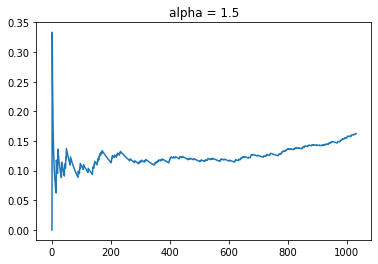

In [6]:

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))

no of aligned time steps: 1010


Text(0.5, 1.0, 'alpha = 1.0')

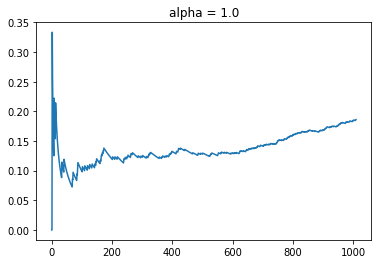

In [7]:

alpha_input = 1.0
data_path = "linucb_disjoint_dataset.txt"
arms_selected, aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)
print(f'no of aligned time steps: {aligned_time_steps}')

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))


no of aligned time steps: 1010


Text(0.5, 1.0, 'alpha = 0.5')

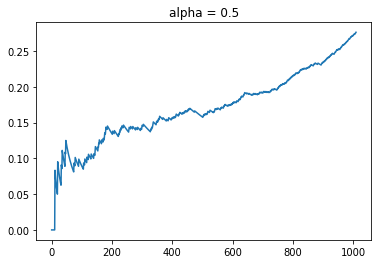

In [8]:

alpha_input = 0.5
data_path = "linucb_disjoint_dataset.txt"
arms_selected, aligned_time_steps, cum_rewards, aligned_ctr, policy = ctr_simulator(K_arms = 10, d = 100, alpha = alpha_input, data_path = data_path)
print(f'no of aligned time steps: {aligned_time_steps}')

plt.plot(aligned_ctr)
plt.title("alpha = "+str(alpha_input))